### Classification

Classification tries to predict which of a set of classes an observation belongs to, where classes are things like "dog or cat". Mathematically, the aim is to find a model $G(X, y)$ where $X$ is a matrix of features constructed from the data, and $y$ is a vector of class labels associated with each row (instance) in $X$, such that the model $G$ does a good job predicting classes given new data $X'$. For instance, consider a doctor trying to assess whether a paitent has heart disease and needs treatment. In this case, the classes are "has heart disease" or "does not have heart disease". To have a machine do this well, we would typically feed the machine a set of data about prior patients along with whether they had heart disease (determined by some other examinations or tests), and *train* the model with the *features* (things observed about the patients, like age, weight, etc.) and the *labels* (whether the patient had heart disease). Then, given the same observations (i.e. the same features) for a *new* patient, the trained model returns the class associated with such observations, which can be used as a predictor of whether the person has heart disease or not.

The main idea on which the Logistic Regression algorithm is based is shown schematically in the image below, for a simple case of two features (a.k.a. 2-D feature space). In its simpler form, the algorithm tries to find a line that divides "things" of two different types in this 2-D feature space. Such a line is usually called a decision boundary, but in general, the decision boundary might have a more complex form, and be in a higher dimensional space (that isn't easily represented in a 2-D chart). Of course, in reality most problems are more complex and are modeled with more than 2 dimensions, as we will see in this Case Study.

![Splitting using a single line](images/onelinesplit.png)



## Case Study Problem Definition: Predicting Heart Disease

We'll use a dataset containing anonymous health information to build models to predict the presence or absence of heart disease from facts and measurements on a group of adults to hone our understanding of classifiers.

### Citing references and data
It's a good idea to cite the sources when you use code and data from somewhere else.  In this case, the data we will use was adapted from:  
  
https://archive.ics.uci.edu/ml/datasets/heart+disease

### About the dataset

There are multiple datasets available at the link, for this study we started with the processed Cleveland data (see [UCI heart disease Cleveland data](https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data)).  We updated the column names to be more self-explanatory, and removed a small number of observations missing one or more values. Please feel free to review the information and references on the UCI site to learn more about the data, as well as see versions with more features.

### The Data Science Process

You should recall from the Guided Capstone, that we are following the Data Science Process:
 - Step One: Problem Identification
 - Step Two: Data Wrangling
 - Step Three: Exploratory Data Analysis
 - Step Four: Pre-processing and Training Data Development
 - Step Five: Modeling
 - Step Six: Documentation
 
In this Case Study, we **won't complete all the steps**, but you should keep them in mind as you progress through the remainder of the project. For example, we have already completed Step One--the problem is to use machine learning to help doctors asses whether a paitent has heart disease or not, using information from examinations. Also, we noted we removed some cases with missing values, as a brief version of Step Two. Importantly, we've will highly abbreviate Step Three--EDA. In most projects you would want to spend considerable time on EDA. Step Four will be addressed as we deal with categorial variables later and split the data into training, validation, and test sets. Most of your time in the Case Study will be spend on Step Five, Modeling. In a complete project, you would often prepare a report or some presentation materials for Step Six, but will not do that here.

We suggest you discuss with your mentor how these various steps can be fully addressed, and consider developing them for "extra credit" 😉.

In this study we are going to use scikit-learn to build classification models, and we need a few other modules to visualize data and manipulate the data before modeling. Here, load the needed modules.

#### Libraries that will be used

In [1]:
%matplotlib inline
#
# data manipulation and math
#
import numpy as np
import scipy as sp
import pandas as pd
#
# plotting and visualization
#
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
#
import seaborn as sns
#
# modeling
#
from sklearn.preprocessing import OneHotEncoder as OHE
import sklearn.model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
#
print("Loaded Libraries")

Loaded Libraries


In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
#
plt.rcParams['figure.figsize'] = (3, 3)
plt.rcParams['figure.dpi'] = 150      
#
c0 = sns.color_palette()[0]
c1 = sns.color_palette()[1]
c2 = sns.color_palette()[2]
#
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
#

As a final step of preparations, we provide two utility functions we will use to illustrate the concepts of classification using logistic regresssion. 

Putting this code in functions makes it efficient to re-use, as well as easier to maintain and fine-tune over time. Feel free to come back to the code for these functions and understand what they do when you use them later in the Case Study.

In [5]:
def points_plot(ax, Xtr, Xte, ytr, yte, 
                clf, 
                mesh = True, colorscale = cmap_light, cdiscrete = cmap_bold, 
                alpha = 0.1, psize = 10, 
                zfunc = False, predicted = False):
#
# note: this function only works for X.shape = (:, 2)
# it is intended to illustrate the classifier boundary
#
# get the column names if they exist to apply
# to the meshed data generated below
#
    try:
        feature_names = Xtr.columns
    except:
        feature_names = None
#        
    Xtrain = np.array(Xtr)
    Xtest = np.array(Xte)
#
    h = 0.02
#
# create a uniform grid spanning the range of the X values
# note that y here is NOT the target, it is the 2nd
# dimension of the desired plot
#
    X = np.concatenate((Xtrain, Xtest))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
#
# predict the target value at each point in the grid
#
# this method uses the probabilities from the classifier
# and applies a function to determine the class
#
    if zfunc:
        mesh_data = np.c_[xx.ravel(), yy.ravel()]
        if feature_names is not None:
            mesh_data = pd.DataFrame(mesh_data, 
                         columns = feature_names)
        p0 = clf.predict_proba(mesh_data)[:, 0]
        p1 = clf.predict_proba(mesh_data)[:, 1]
        Z = zfunc(p0, p1)
#
# this method uses the classifier to predict the classes directly
#
    else:
        mesh_data = np.c_[xx.ravel(), yy.ravel()]
        if feature_names is not None:
            mesh_data = pd.DataFrame(mesh_data, 
                                     columns = feature_names)
        Z = clf.predict(mesh_data)
    ZZ = Z.reshape(xx.shape)
#
# plt.pcolormesh() creates a shaded result over the grid
#
    if mesh:
        plt.pcolormesh(xx, yy, ZZ, 
                       cmap = cmap_light, 
                       alpha = alpha, 
                       axes = ax, 
                       shading = 'auto')
#
# add the points to the plot
# these can be the original target values
# or the predicted values
#
    if predicted:
        showtr = clf.predict(Xtr)
        showte = clf.predict(Xte)
    else:
        showtr = ytr
        showte = yte
#
# plot training points
#
    ax.scatter(Xtrain[:, 0], Xtrain[:, 1], 
               c = showtr - 1, 
               cmap = cmap_bold, 
               s = psize, 
               alpha = alpha, 
               edgecolor = "k")
#    
# plot testing points
#
    ax.scatter(Xtest[:, 0], Xtest[:, 1],
               c = showte - 1, 
               cmap = cmap_bold, 
               s = psize + 10,
               alpha = alpha, 
               marker = "s")
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
#
    return ax, xx, yy

In [6]:
def points_plot_prob(ax, Xtr, Xte, ytr, yte, 
                     clf, colorscale = cmap_light, cdiscrete = cmap_bold, 
                     ccolor = cm, 
                     alpha = 0.1, psize = 10):
    try:
        feature_names = Xtr.columns
    except:
        feature_names = None
#        
    Xtrain = np.array(Xtr)
    Xtest = np.array(Xte)
#    
    ax, xx, yy = points_plot(ax, Xtr, Xte, ytr, yte,
                         clf,
                         mesh = False, 
                         colorscale = colorscale, cdiscrete = cdiscrete, 
                         psize = psize, alpha = alpha,
                         predicted = True) 
    mesh_data = np.c_[xx.ravel(), yy.ravel()]
    if feature_names is not None:
        mesh_data = pd.DataFrame(mesh_data, 
                     columns = feature_names)    
    Z = clf.predict_proba(mesh_data)[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap = ccolor, alpha = 0.2)
    cs2 = plt.contour(xx, yy, Z, cmap = ccolor, alpha = 0.6)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize = 12)
#
    plt.show()

#### Loading the data

As a first step, read in the data and view all the columns, and display the top of the DataFrame using head().

In [7]:
dflog = pd.read_excel("./data/heart.xlsx")
#
print('The data have ', dflog.shape[0], ' rows and ', dflog.shape[1], ' columns\n')
print('column names: \n')
print('\n'.join(list(dflog.columns)))

The data have  270  rows and  14  columns

column names: 

age_yr
sex_M_F
chest_pain_value
resting_BP_mm_Hg
cholesterol_mg_dl
fasting_blood_sugar_high
ECG_value
max_HR
exercise_angina
ST_depresssion_exercise
ST_slope_peak
number_vessels_involved
defect_diag
heart_disease


#### "Minimal EDA"

Earlier we reviewed the Data Science Process and noted we would not fully complete all steps here, and in particular much more time would normally be spent on Exploratory Data Analysis (EDA). Here, we look at the first few rows of the data, plot the variables to get a feel for the data, then apply some necessary transformations followed by inspecting the distribution of the two result classes (heart disease present or not present).

In [8]:
dflog.head()

,age_yr,sex_M_F,chest_pain_value,resting_BP_mm_Hg,cholesterol_mg_dl,fasting_blood_sugar_high,ECG_value,max_HR,exercise_angina,ST_depresssion_exercise,ST_slope_peak,number_vessels_involved,defect_diag,heart_disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,1
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,0
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,1
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,0
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,0


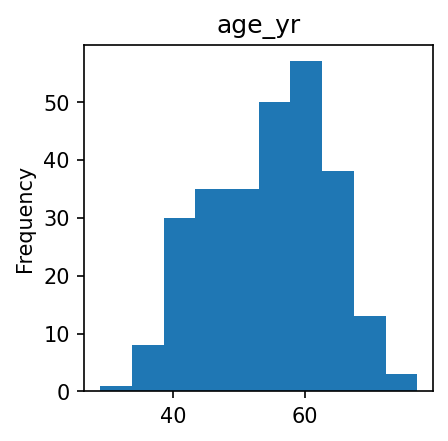

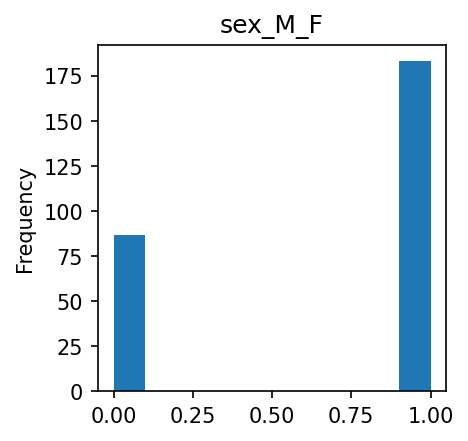

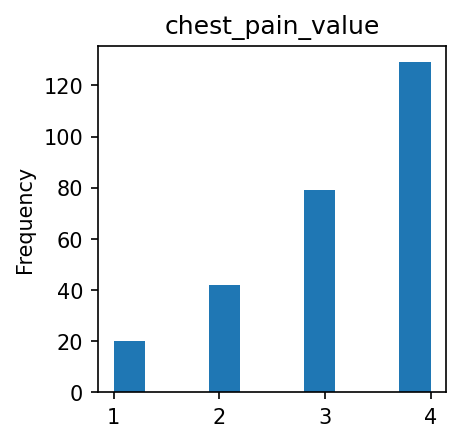

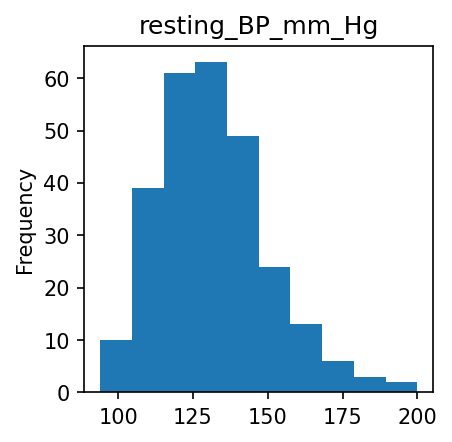

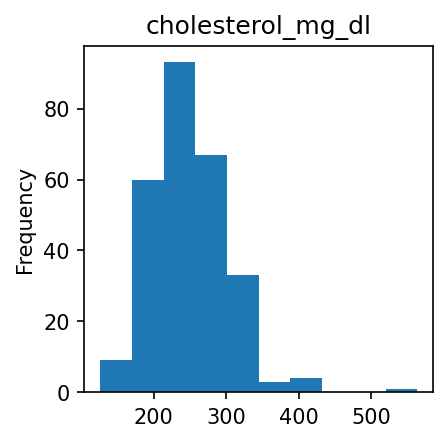

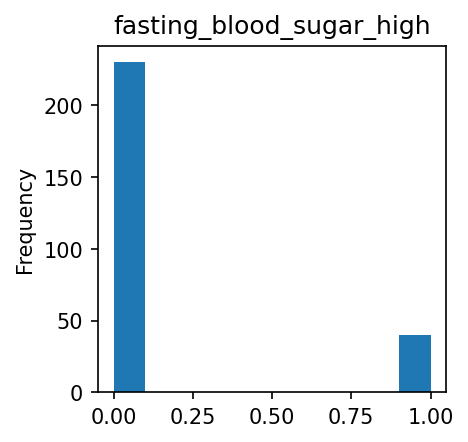

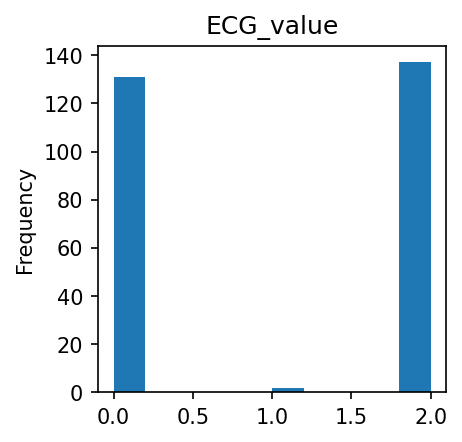

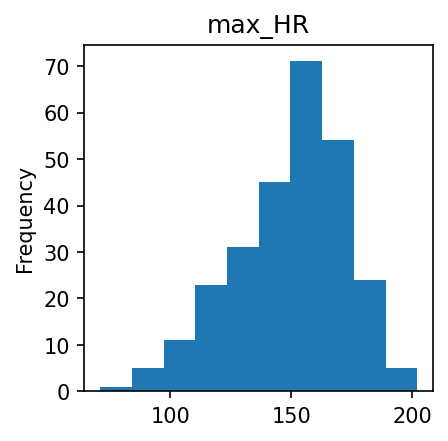

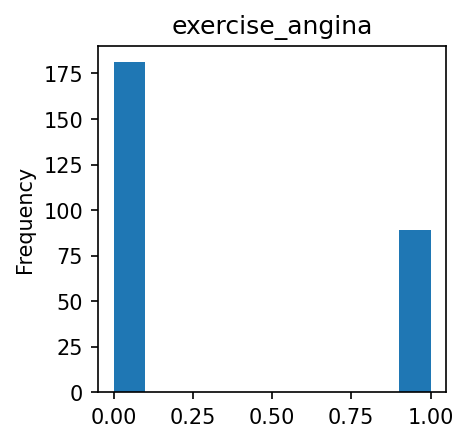

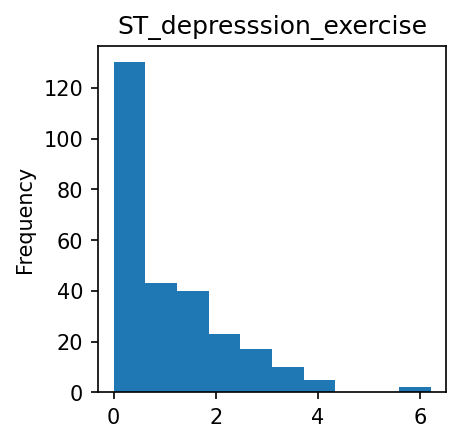

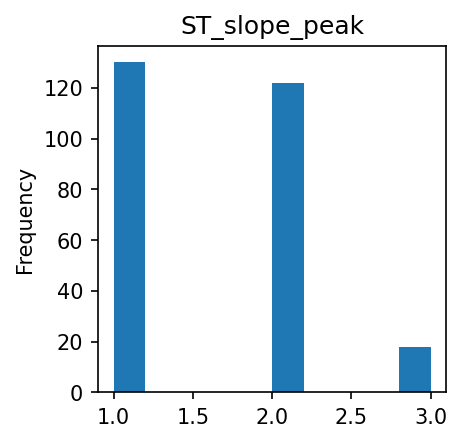

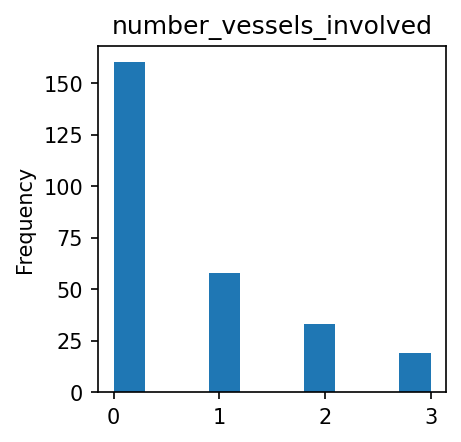

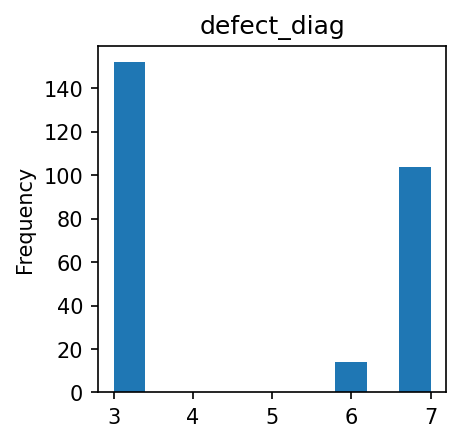

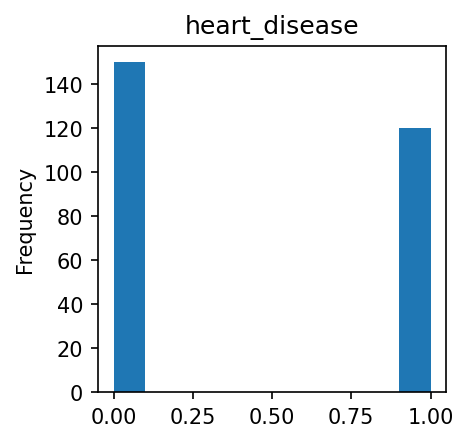

In [9]:
for col in list(dflog.columns):
    dflog[col].plot(kind = 'hist', title = col)
    plt.show()

Without completing a full EDA, we can see that some variables take on values that denote classes or categories (such as sex_M_F, fasting_blood_sugar_high), and thus are categorical, and some take on values that are a measure (such as age, blood pressure, cholesterol) and therefore are non-categorical.  Depending upon the models you choose to apply to these data, some additional preparation might be in order, such as ensuring the non-categorical values are all in sensible ranges (such as, what is a feasbile maximum value for cholesterol?), possibly scaling some of the variables, and generally ensuring you understand the data and they are suitable for a given model, to mention only a few.  Here, we will need to transform the categorical values to use them in a logistic regression model, which we will come to shortly.

Before moving on to modeling, let's look at some of the features of the dataset.

> **Note**  
Moving forward, we might use the terms "variable" and "feature" interchageably, to represent the concept of the independent or $\textbf{X}$ data. In general, there might be nuanced differences in these concepts, such as variable referring to the orignal data and feature referring to a transformed version of it.

In [10]:
#
# extract the age as a Series, and inspect the values
#
x = dflog['age_yr']
print('first 6 lines of age data:\n', x.head(6))
print('\nsummary statistics of age:\n', x.describe())

first 6 lines of age data:
 0    70
1    67
2    57
3    64
4    74
5    65
Name: age_yr, dtype: int64

summary statistics of age:
 count    270.000000
mean      54.433333
std        9.109067
min       29.000000
25%       48.000000
50%       55.000000
75%       61.000000
max       77.000000
Name: age_yr, dtype: float64


In [11]:
#
# do the same for the resting blood pressure
#
y = dflog['resting_BP_mm_Hg']
print('first six lines of blood pressure data:\n', y.head(6))
print('\nsummary statistics of blood pressure:\n', y.describe())

first six lines of blood pressure data:
 0    130
1    115
2    124
3    128
4    120
5    120
Name: resting_BP_mm_Hg, dtype: int64

summary statistics of blood pressure:
 count    270.000000
mean     131.344444
std       17.861608
min       94.000000
25%      120.000000
50%      130.000000
75%      140.000000
max      200.000000
Name: resting_BP_mm_Hg, dtype: float64


#### Transformation of categorical features

In general, categorical features need to be transformed or *encoded* to be used in some machine learning models, as is the case for Logistic Regression. A common transformation is so-called *dummy encoding*, where each possible value of a feature becomes a new column, and a 1 is placed in that column if the data instance (a row of the data) contained that value, and a 0 is placed in that column otherwise.  

For example, suppose we had a column in a hypothetical data set called species, and it contained one of two values, "cat" or "dog". The column might look like this:
```
species
cat
cat
dog
dog
cat
dog
...
```

Dummy encoding would replace this with two columns:
```
species_cat   species_dog
    1              0
    1              0
    0              1
    0              1
    1              0
    0              1
   ...            ...
```
This method extends to as many unique values there are in a given feature. Here we use the Pandas method get_dummies() (*) to transform a subset of columns. Note how we can specify which columns we want to be transformed, so we make a list of them first. If the columns are not specified, Pandas will decide which columns are categorical based on the Pandas type, and convert those. This can be convenient but is not always what is desired. For clarity, we explicitly define them here.

---
 (*) [pandas.get_dummies()](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html)

In [12]:
categorical_features = ['sex_M_F',
                        'chest_pain_value',
                        'ECG_value',
                        'ST_slope_peak',
                        'defect_diag']
dflog = pd.get_dummies(dflog, columns = categorical_features)
print('The data have ', dflog.shape[0], ' rows and ', dflog.shape[1], ' columns\n')
print('column names: \n')
print('\n'.join(list(dflog.columns)))

The data have  270  rows and  24  columns

column names: 

age_yr
resting_BP_mm_Hg
cholesterol_mg_dl
fasting_blood_sugar_high
max_HR
exercise_angina
ST_depresssion_exercise
number_vessels_involved
heart_disease
sex_M_F_0
sex_M_F_1
chest_pain_value_1
chest_pain_value_2
chest_pain_value_3
chest_pain_value_4
ECG_value_0
ECG_value_1
ECG_value_2
ST_slope_peak_1
ST_slope_peak_2
ST_slope_peak_3
defect_diag_3
defect_diag_6
defect_diag_7


#### Proportion of classes
When building classification models, it is always a good idea to know right away the number of samples per class, proportionally to the total number of samples. First we get the counts of each class.

In [13]:
class_counts = dflog['heart_disease'].value_counts()
class_counts

heart_disease
0    150
1    120
Name: count, dtype: int64

Notice that class_counts is a Pandas Series object:

In [14]:
type(class_counts)

pandas.core.series.Series

We can easily compute the relative frequencies (percentages) to better quantify differences in the incidences of the classes:

In [15]:
class_percentages = pd.Series([(x / dflog.shape[0]) * 100.00 for x in class_counts])
class_percentages

0    55.555556
1    44.444444
dtype: float64

Now we can use the percentages as labels and plot the distribution of the two classes:

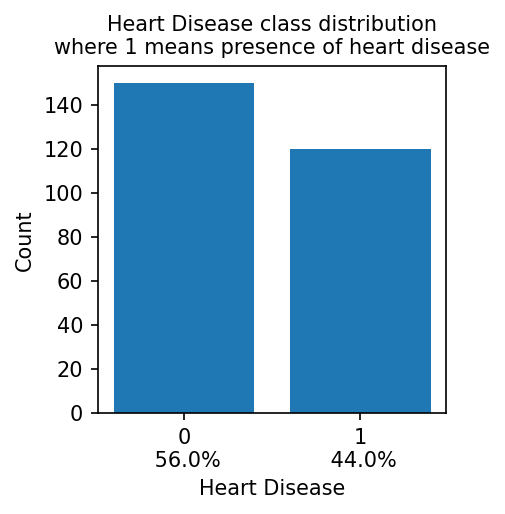

In [16]:
fig, ax = plt.subplots()
ax.bar(class_counts.index, class_counts)
ax.set_xticks([0, 1])
ax.set_xticklabels(class_percentages.index.astype(str) + '\n' + ' ' +
                   class_percentages.round(0).astype(str) + '%')
ax.set_ylabel('Count')
ax.set_xlabel('Heart Disease')
ax.set_title('Heart Disease class distribution\nwhere 1 means presence of heart disease',
              fontsize = 10)
plt.show()

The code above can be easily generalized to handle multiple classes, and we invite you to give it a try, in consulation with your mentor.

#### Side-Bar: Balanced and Imbalanced Classes
For a binary classification problem (two classes), the problem is called *balanced* if the number of elements of each class is about the same--in other words, each class would have a size that is about 50% of the total number of elements in the dataset. In this particular case study, one would say that this problem is slightly imbalanced, since the difference in the percentages is about 10%. When there is a imbalance among the classes in a binary classification problem, one usually refers to them as the *minority class*, and the *majority class*.

In practice, *Imbalanced Classification Problems* (ICP) are very common in situations where one is modeling events that are not common, and thus these events would be instances of the *minority* class. Examples of these problems include: study of diseases such as Cancer, study of processes such as fraud, and--in general--the study of rare anomalies within a system. It is common to find instances of these problems where the difference in the percentages is 80% or more.

There are two important challenges posed by ICPs:

- The difference in the size of the classes is *inherent* to the problem under study. This means that one cannot pave this difference by adding more elements to the minority class.

- Classification algorithms are usually negatively affected by the lack of sufficient samples of the minority class, in that the models built with them are practically unable to differentiate the minority class from the majority class, where the former is the one of interest. For instance, imagine a model built to compute the likelihod of a patient developing Cancer that nearly always predicts a small likelihood for this class (meaning, that the model predicts NO Cancer, when it should have predicted Cancer in some cases).

Since this particular case study deals with a slight imbalance among the classes, we might be able to build useful models with the given dataset--without introducing additional interventions. One general approach to deal with ICP is by either generating sythetic data (a.k.a. *oversampling*), or by generating a set of smaller "majority classes" by taking chunks from the original majority class (a.k.a. *undersampling*). In general, these approaches are collectively referred to as *resampling*.

We will not practice these concepts in this case study, but you might have the opportinity to do so in your capstone projects. Discuss this possibility with your mentor if/when applicable.

Finally, the concepts discussed above can be easily generalized to ICPs with a number of classes greater than 2 (*Imbalanced Multi-Class Classification Problems*--IMCP).

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<ul>
  <li> <b>Exercise:</b> Create a scatter plot of Blood Pressure vs. Cholesterol Level
  <li> <b>Exercise:</b> Color the points differently by the Presence of Heart Disease
</ul>
</div>

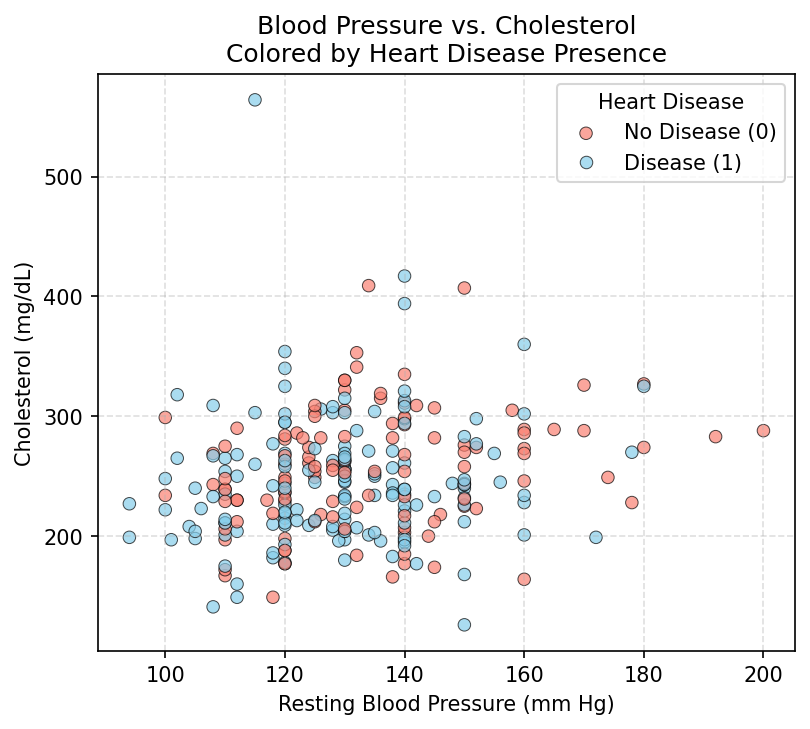

In [17]:
# Create the scatter plot
plt.figure(figsize=(6, 5))
sns.scatterplot(
    data=dflog,
    x='resting_BP_mm_Hg',       # X-axis: blood pressure
    y='cholesterol_mg_dl',      # Y-axis: cholesterol
    hue='heart_disease',        # Color by heart disease presence
    palette={0: 'skyblue', 1: 'salmon'},  # Custom color palette
    alpha=0.7,                  # Slight transparency for clarity
    edgecolor='k'               # Thin black border around points
)

# Add titles and labels
plt.title('Blood Pressure vs. Cholesterol\nColored by Heart Disease Presence')
plt.xlabel('Resting Blood Pressure (mm Hg)')
plt.ylabel('Cholesterol (mg/dL)')
plt.legend(title='Heart Disease', labels=['No Disease (0)', 'Disease (1)'])
plt.grid(True, linestyle='--', alpha=0.4)

# Display the plot
plt.show()


#### Optional: Building a Logistic Regression Model with Only Two Features

We want to demonstrate a simple case where $X$ has only two dimensions and therefore we can plot the classification results in an x-y plot. The utility function we provided will shade the classifier results for the two target classes, on a plot of the two $X$ features. To do this, we'll choose just two of the features of the heart disease data.

Recall our features are:
```
age_yr
resting_BP_mm_Hg
choleterol_mg_dl
fasting_blood_sugar_high
max_HR
exercise_angina
ST_depresssion_exercise
number_vessels_involved
heart_disease
sex_M_F_0
sex_M_F_1
chest_pain_value_1
chest_pain_value_2
chest_pain_value_3
chest_pain_value_4
ECG_value_0
ECG_value_1
ECG_value_2
ST_slope_peak_1
ST_slope_peak_2
ST_slope_peak_3
defect_diag_3
defect_diag_6
defect_diag_7
```

...of which we are choosing for this example: ``cholesterol`` and ``blood pressure``.

#### The model building cycle
 
Now we apply the pattern that should be familiar to you:

> (a) train/test split  
> (b) create an object of the class associated with the algorithm to be
 used--in this case LogisticRegression  
> (c) build an actual model using the "fit" method from the class (applied to the training set)  
> (d) predict with the built model using the "predict" method from the class (training set and test set)  
> (e) compute performance metrics (in this case, accuracy) for the training and test predictions  

consider

> (a) how the parameters passed to train_test_split are computed "on-the-fly", what their types are expected to be, and what are the values of the parameters that are not passed explicitly, which will take the default values per the documentation of the method train_test_split ...  

> The documentation can be viewed at: [sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) or you can run ``help(train_test_split)`` in a notebook cell after the module has been imported

In [18]:
Xtrain, Xtest, ytrain, ytest = train_test_split(dflog[['cholesterol_mg_dl','resting_BP_mm_Hg']],
                                                dflog['heart_disease'],
                                                train_size = 0.80,
                                                random_state = 42)

> (b) create an object of the class associated with the algorithm to be used--in this case LogisticRegression: also, compare the parameters passed against the expected parameters, and default parameters being used per the documentation of the constructor of class LogisticRegression

> The documentation can be viewed at: [sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) or you can run ``help(LogisticRegression)`` in a notebook cell after the module has been imported

In [19]:
classifier = LogisticRegression(solver = 'liblinear', max_iter = 500, C = 1000)

> (c) create an actual model using the "fit" method for the class applied to the training set

In [20]:
classifier.fit(Xtrain, ytrain)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1000
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,500
,multi_class,'deprecated'


> (e.1) compute performance metrics (in this case, accuracy) for the training and test predictions... notice how accuracy_score receives the result from classifier.predict(Xtrain), and compares it with ytrain to produce the training accuracy 

> the documentation can be viewed at: [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) or you can run ``help(accuracy_score)`` in a notebook cell after the module has been imported

In [21]:
print(f'Accuracy on training data: {accuracy_score(classifier.predict(Xtrain), ytrain):.2f}')

Accuracy on training data: 0.61


> (e.2) compute performance metrics (in this case, accuracy) for the training and test predictions... notice how accuracy_score receives the result from classifier.predict(Xtest), and compares it with ytest to produce the testing accuracy

In [22]:
print(f'Accuracy on test data: {accuracy_score(classifier.predict(Xtest), ytest):.2f}')

Accuracy on test data: 0.59


as mentioned above, we can now see graphically how the model is differentiating elements of both classes after being built with only two features (Cholesterol Level, and Resting Blood Pressure)

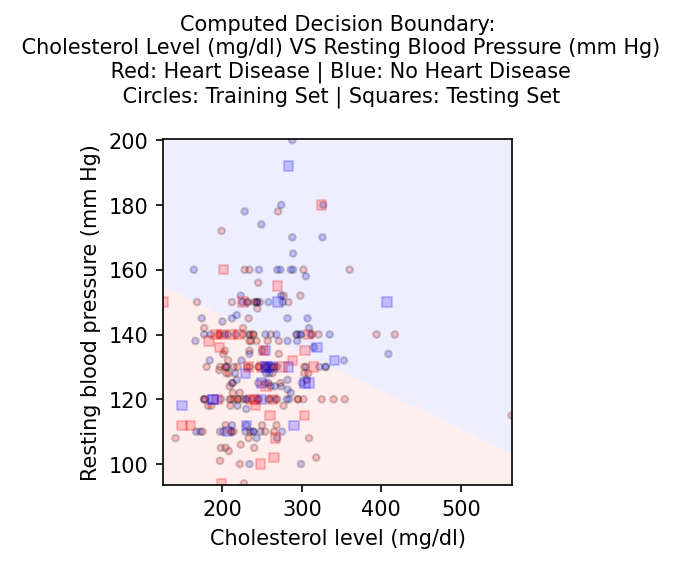

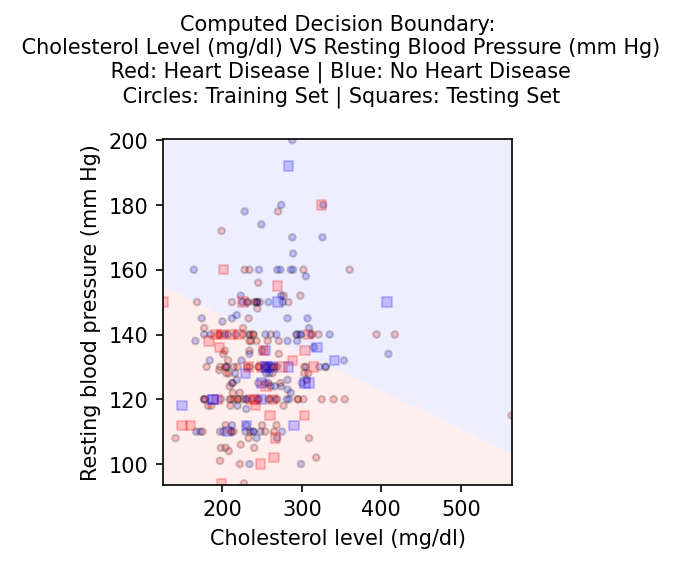

In [24]:
plt.figure()
ax = plt.gca()
ax.set_ylabel('Resting blood pressure (mm Hg)')
ax.set_xlabel('Cholesterol level (mg/dl)')
ax.set_title('Computed Decision Boundary:\n ' +
             'Cholesterol Level (mg/dl) VS Resting Blood Pressure (mm Hg)' +
             '\n Red: Heart Disease | Blue: No Heart Disease' +
             '\n Circles: Training Set | Squares: Testing Set\n',
            fontsize = 10)
_ = points_plot(ax, Xtrain, Xtest, ytrain, ytest, classifier, alpha = 0.2)

plt.show()

We can (and should) use sklearn's classification_report() function to see more details about what the classifier is actually doing.  You should be familiar with these additional metrics. 

In [25]:
print("Classification Report for Training Data")
print(classification_report(ytrain, classifier.predict(Xtrain)))

Classification Report for Training Data
              precision    recall  f1-score   support

           0       0.61      0.78      0.68       117
           1       0.61      0.40      0.48        99

    accuracy                           0.61       216
   macro avg       0.61      0.59      0.58       216
weighted avg       0.61      0.61      0.59       216



In [26]:
print("Classification Report for Test Data")
print(classification_report(ytest, classifier.predict(Xtest)))

Classification Report for Test Data
              precision    recall  f1-score   support

           0       0.63      0.82      0.71        33
           1       0.45      0.24      0.31        21

    accuracy                           0.59        54
   macro avg       0.54      0.53      0.51        54
weighted avg       0.56      0.59      0.56        54



#### Some Comments on this Result

In the figure, class 0 (no heart disease) is shaded red, and class 1 (heart disease) is shaded blue.  The train labels are plotted as circles, using the same color scheme, while the test data are plotted as squares.  Some points that are evident for this simple classifier:

- The classifier tends to suggest heart disease as either blood pressure or choleterol increase.  This seems intuitively correct.
- The classifier isn't very good!  The accuracy on the training data is only 61%, and the accuracy on the testing data is barely better than random chance (59%)--where random chance if 50%.  This isn't surprising since we are using only two features.
- Moreover, notice that the classification report shows that the model performs poorly when trying to recognize inputs that belong to class 1 (*the class of interest*), which is indicated by the poor values of precision, recall, and f1-score for class 1--for the training set and test set.
- The "decision boundary" is a line. As we add more features, we won't be able to represent the boundary this way. The boundary becomes what is called a hyperplane, which is the generalization of a line into 3 or more dimensions. But here, a patient measured with a combination of cholesterol and blood pressure to the right of the line (in the blue region) would be classified as likely having heart disease.

We now move on to investigate how to get a better classifier that is optimized on the data and will perform well in the future.

### Building a Logistic Regression Model with all Features

After having seen the results of a model built with only two features, we are now going to turn our attention to building a full-fledged model using all the features, and will compare this model with the previous one, with respect to several performance metrics. 


<b>We will follow the same pattern we used before, only this time we are explicitly defining two objects ``X`` and ``y``, which were defined implicitly when we built the first model</b>. 

    
Thus, pattern defined above can be expanded as follows:

> (a) Define ``X`` and ``y``  

> (b) Perform train/test split on ``(X, y)``  

> (c) Create an object of the class associated with the algorithm to be used--in this case ``LogisticRegression``  

> (d) Build an actual model using the``fit`` method from the class associated with the algorithm 
to be used (using the training set)  

> (e) Predict with the built model using the``predict`` method from the class (training set and test set)  

> (f) Compute performance metrics (in this case, accuracy) for the training and test predictions. The metrics to be used and their interpretation will depend on the application at hand  

> (g) Determine if the model can be improved--repeat as needed with additional algorithms and/or by applying hyper-parameter tuning  

> (h) Compare and Combine all best models as needed

#### (a) Define ``X`` and ``y``  

X contains the independent variables--a.k.a. features, but not the target. X is usually referred to as the "Design Matrix", in this case it will be represented as a data frame.

The following is a very convenient way to express this using Pandas--indeed, the .drop(...), means "remove the column 'heart_disease' ..."

In [27]:
X = dflog.drop(columns = ['heart_disease'])
print("X: ", type(X), X.shape)

X:  <class 'pandas.core.frame.DataFrame'> (270, 23)


Notice that ``X`` is a ``pandas`` DataFrame with 270 rows and 23 columns (a.k.a. a matrix).

Remember that the form of data we will use always is

<img src="images/dataform.jpg" alt="data form" style="width: 600px;"/>

y is the dependent variable, sometimes known as the response, target, or labels. In this case, it is the presence or absence of heart disease.

In [28]:
y = dflog['heart_disease']
print("y: ", type(y), y.shape)

y:  <class 'pandas.core.series.Series'> (270,)


notice that, by construction, y will have value True (1) in positions where  the value for the heart_disease column of the dataframe is 1, otherwise it will be False (0).

So the "response" $y$ is a plain array of 0s and 1s for binary classification. 

`y = [1,1,0,0,0,1,0,1,0....]`.

Sometimes we will also see -1 and +1 instead. There are also *multiclass* classifiers that can assign an observation to one of $K > 2$ classes and the labe may then be an integer, but we will not be discussing those here.

Exactly as expected, $y$, is a pandas Series, aka a vector of 270 components. Moreover, we invite you to check that the following relationship holds between $X$ and $y$:

1. They have the same number of rows
2. For a given row $i$ of matrix $X$, the label that corresponds to that data point is exactly the value of vector $y$ at that row
3. The number of rows of $X$ is the number of data points in the dataset
4. The number of columns of $X$ is the number of features of each data point in the dataset

and ... we can check that the columns contain all the features but not the target in this case, we can do it visually, but think about how to do it in Python, for cases were the number of columns is too large to check visually:

In [29]:
list(X.columns)

['age_yr',
 'resting_BP_mm_Hg',
 'cholesterol_mg_dl',
 'fasting_blood_sugar_high',
 'max_HR',
 'exercise_angina',
 'ST_depresssion_exercise',
 'number_vessels_involved',
 'sex_M_F_0',
 'sex_M_F_1',
 'chest_pain_value_1',
 'chest_pain_value_2',
 'chest_pain_value_3',
 'chest_pain_value_4',
 'ECG_value_0',
 'ECG_value_1',
 'ECG_value_2',
 'ST_slope_peak_1',
 'ST_slope_peak_2',
 'ST_slope_peak_3',
 'defect_diag_3',
 'defect_diag_6',
 'defect_diag_7']

***All classification problems can be represented, as shown above, with a matrix $X$ and a vector  $y$, satisfying the conditions 1-4 above***. When the number of unique values of $y$ is 2, the problem is called a binary classification problem. When this number is greater than 2, the problem is called a multi-class classification problem. In this Case Study we are dealing with the former.

#### (b) Perform train/test split on $(X, y)$

In [30]:
Xlr, Xtestlr, ylr, ytestlr = train_test_split(X, y, random_state = 2)
print('Training split has ', Xlr.shape[0], ' rows\n',
      'and the corresponding labels have an equal number of values.', 
      '(' + str(len(ylr))+ ')')
print('Test split has ', Xtestlr.shape[0], ' rows\n',
      'and the corresponding labels have an equal number of values.', 
      '(' + str(len(ytestlr)) + ')')

Training split has  202  rows
 and the corresponding labels have an equal number of values. (202)
Test split has  68  rows
 and the corresponding labels have an equal number of values. (68)


We notice the following:

- This time we did not include the split parameter in the call to ``train_test_split``, and thus it computed a 75% / 25% split of the data as we verified above. This is the deafult split as per the documentation of this method (*).


- We used a different value for ``random_state`` to indicate that if we were to call ``train_test_split`` with the same arguments ``X`` and ``y``, the function would return the same split as the first time--which would be useful in cases where identical splits need to be used. Notice that this is not guaranteed to happen across notebooks; but if this were the case, we could persist the split (that is, saving it to the local storage--e.g., hard disk) ``Xlr, Xtestlr, ylr, ytestlr`` (e.g., using Pickle or other methods (+)).


- When we built our first model, we talked about the importance of exploring the proportion among the classes in terms of their sizes, but we did not talk about what could happen to that proportion after the train/test split is executed. In our case, we saw before that the proportion between classes ``0`` (no heart disease), and ``1`` (heart disease) is about 56% for class ``0``, and 44% for class ``1``--and thus, this is a slightly imbalanced classification problem, where class ``1`` is the minority class. So, it makes sense to ask whether this proportion is preserved in ``ylr, ytestlr``.


The code below investigates this question. 

---


(*) [sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

(+) [docs.python.org pickle](https://docs.python.org/3/library/pickle.html)

Here we define a function to plot the class ratios between two splits of the data.

In [31]:
def plot_y_ratios(y, ytest):
    fig, ax = plt.subplots(2, sharex = True)
    ax[0].bar(x = [0, 1], height = [y[y == 0].count(), 
                                    y[y == 1].count()])
    ax[0].set_ylabel('train', fontsize = 8)
    ax[0].set_ylim(0, 125)
    ax[1].bar(x = [0, 1], height = [ytest[ytest == 0].count(),
                                    ytest[ytest == 1].count()])
    ax[1].set_ylabel('test', fontsize = 8)
    ax[1].set_ylim(0, 125)
    ax[1].set_xticks([0, 1])
    ax[0].tick_params(which = 'both', labelsize = 8)
    ax[1].tick_params(which = 'both', labelsize = 8)
    ax[1].set_xlabel('heart disease\n(0 = no disease)', fontsize = 8)
    ax[0].set_title('% heart disease (where 1 means presence of heart diseases):\n' +
                    'train: ' + str(round(100 * (y[y ==1].count()/y.shape[0]), 0)) +
                    '\ntest: ' + str(round(100 * (ytest[ytest ==1].count()/ytest.shape[0]), 0)),
                   fontsize = 10)
    plt.show() 

Now we can inpsect the train response data (ylr) compared to the test response data (ytestlr).

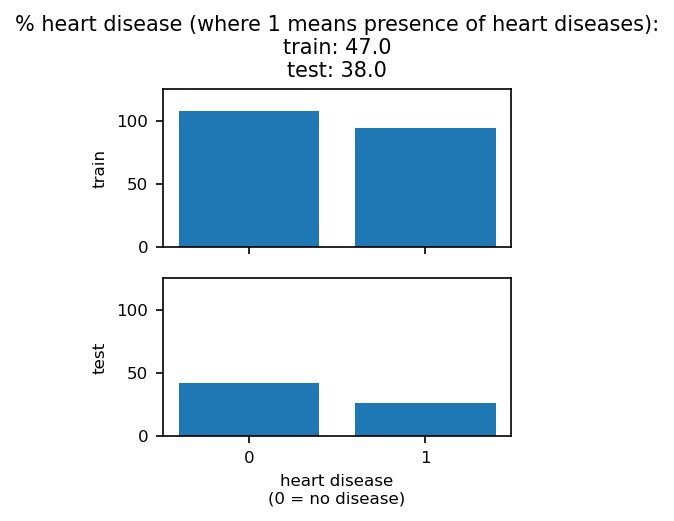

In [32]:
plot_y_ratios(ylr, ytestlr)

We see that ```ytestlr``` has a lower percentage of heart disease (38%), compared to the percentage in the original dataset (44%). Thus, the way we used train/test split made the imbalance (however mild) a little worse. As discussed before, we would like to perform a split preserving the original proportions among the classes, so we do not have to worry about the possibility of getting poor results due to this fact.

It turns out that ```train_test_split``` provides a way to compute splits that try to preserve (as much as it might be possible) the proportions among the classes in the original dataset. More specifically, the *stratify* parameter takes an *array-like* object that describes all the classes (*). Thus, we can use the target as this parameter. Below we specify to stratify according to ``y``, and then inspect the resulting split. Notice that this method works for multiple classes as well (i.e., number of classes greater than 2).

---
(*) [sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

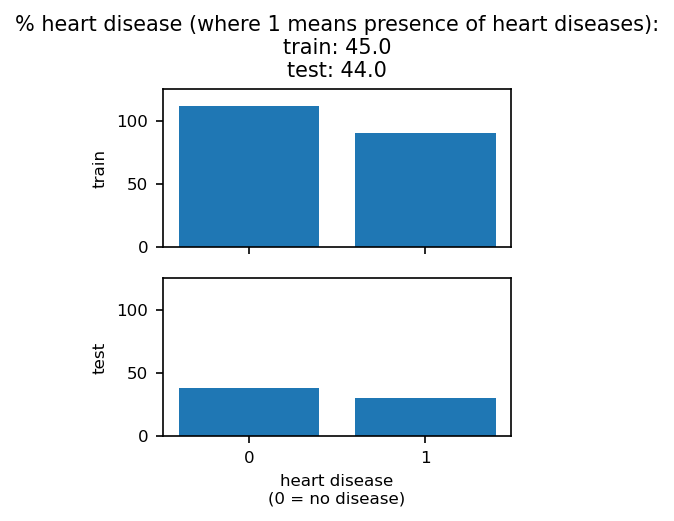

In [33]:
Xlrstrat, Xtestlrstrat, ylrstrat, ytestlrstrat = train_test_split(X, y, 
                                                                  random_state = 2, 
                                                                  stratify = y)
plot_y_ratios(ylrstrat, ytestlrstrat)

Nearly perfect!  As noted earlier, in a more complete project you should do EDA on the X-variables as well, and consider if the distributions there are of a concern, before moving on to modeling. 

<b> To recap ... </b>, the binary classification problem has been represented as:

- A *design matrix* $X$, with as many rows as there are rows in the dataset, and
as many columns as there are features in the dataset


- A *target vector* $y$, with as many elements as there are rows in the dataset, and it is
such that the i-th value of $y$ is the value of the target associated with 
row i of $X$.

A very important fact to consider is this:

*Any <b>supervised</b> problem can be represented by a pair $(X, y)$, where $X$ is a
design matrix, and $y$ is a target vector*.

- The values in $y$ may be *imbalanced*, and in general it's good practice to ensure the data splits have similar distributions of the target.

Morevover: 

- When the target vector takes non-categorical values, ``(X, y)`` represents a *<b>regression</b>* problem.

- When the target vector takes categorical values, ``(X, y)`` represents a *<b>classification</b>* problem.

$Note$: there are *unsupervised* problems which are represented by a design matrix $X$ but there is no corresponding $y$. We don't further address *unsupervised* problems in this Case Study.

We are ready to continue building a model.

#### (c) Create an object of the class associated with the algorithm to be used--in this case LogisticRegression

Construct the LogisticRegression object, setting some basic parameters (more on this later). See (*) for more details, and discuss with your mentor the meaning of each parameter, and the implications associated with using default values

---
 (*) [sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [34]:
clf = LogisticRegression(solver = 'newton-cg', max_iter = 500)

#### (d) Build an actual model using the ``fit `` method from the class associated with the algorithm to be used (using the training set)

In [35]:
clf.fit(Xlrstrat, ylrstrat) 

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'newton-cg'
,max_iter,500
,multi_class,'deprecated'


#### (e) Predict with the built model using the ``predict`` method from the class (training set and test set)

In [36]:
y_predict_test = clf.predict(Xtestlrstrat)
y_predict_training = clf.predict(Xlrstrat)

#### (f) Compute performance metrics (in this case, accuracy) for the training and test predictions. In general, the metrics to be used and their interpretation will depend on the application at hand

In [37]:
print("[Test] Accuracy score (y_predict_test, ytestlrstrat):",
      f'{accuracy_score(y_predict_test, ytestlrstrat):.2f}')

[Test] Accuracy score (y_predict_test, ytestlrstrat): 0.81


Note the order in which the parameters should be passed according to the documentation ... although in this case there is no difference since it is a one-to-one comparison

ref: [sklearn.metrics.accuracy_score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)

Re-compute with switched order to confirm what we expect

In [38]:
print("[Test] Accuracy score: (ytestlrstrat, y_predict_test) [**note reversed order]", 
      f'{accuracy_score(ytestlrstrat, y_predict_test):.2f}')

[Test] Accuracy score: (ytestlrstrat, y_predict_test) [**note reversed order] 0.81


And compute the metric on the training data:

In [39]:
print("[Training] Accuracy score: (ylrstrat, y_predict_training)", 
      f'{accuracy_score(ylrstrat, y_predict_training):.2f}')

[Training] Accuracy score: (ylrstrat, y_predict_training) 0.89


#### (g) Determine if the model can be improved--repeat as needed with additional algorithms and/or by applying hyper-parameter tuning

It is common practice to show--when applicable--performance metrics for both the training set and the test set. This means that the model is fitted with the training set, and once fitted, predictions are generated using the training set and the test set, and the corresponding performance metrics are shown (as above), and analyzed. 


*NOTE*: you might want to discuss with your mentor examples of cases when this comparison would *not* be applicable. 


*Hint*: consider tree-based algorithms such as Random Forest Classifiers. (*)

Since the model's **training accuracy** (``0.89``) is pretty good (meaning, close to 1--or 100%), then one says there is only a small "bias" in the model.

Since the model's **test accuracy** (``0.81``) is decently close to the training accuracy, we would say that there is a small "variance" between the training accuracy and the test accuracy. This is an indication that the model will "generalize well", which means that the model will be well-behaved when new data is presented to it.

Since the gap between training and testing accuracy is about 8%, one might say that the model is slightly over-fitting the data. Thus, in general, one says that a model is *over-fitting* (or just overfitting), when there is an important gap between its training performance and its test performance.

Notice two points of nuance in the definition of overfitting: (a) the quantification of *important* depends on the application; and (b) the comparison of training versus test performance can be done (in many cases) across mulriple performance metrics 

These properties are important and desirable.

In this particular case study, however, there are two possible avenues that we might want to investigate:


- Whether the mild imbalance in the dataset might be affecting the algorithm (and thus the model computed with it.)


- Whether the observed mild overfitting can be diminished


Below we explore the second bullet. Feel free to consult with your mentor for resources associated with exploring the first bullet.

---
(*) [sklearn.ensemble.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

#### Side-Bar: NEVER EVER use just Accuracy to Measure the Performance of a Classification Algorithm!

Note however that focusing only on accuracy is not a good practice since in some cases it can be misleading. In particular, if the dataset is highly imbalanced (as defined before), then accuracy becomes a poor indicator of model performance.  For example, suppose we were given a data sample of 1000 instances, and 900 of them were class ``1``, and 100 were class ``0``.  

If we defined a model that always predicts class ``1``, such model would have 90% accuracy! But we would be mis-classifying 100% of the class 0 samples--although 10% of the time, with respect to the whole dataset.  

A good way to avoid this trap is by always generating a confusion matrix for a classification result.  The confusion matrix is simply a table with the true class labels on one axis, and the predicted labels on the other axis.  The counts for each combination of true vs. predicted are put in each cell of the table.  For our hypothetical case, the confusion matrix is:

<img src = "images/Confusion_Matrix.jpg" alt = "confusion matrix" style="width: 400px;"/>

Note that the diagonal intersections of the classes are the "correct" predictions (i.e. Predicted 0 intersection wiht Actual 0, and Predicted 1 intersection with Actual 1), and in this case since the model never predicts 0, there are no "correct" predictions for that case. It is easy to see that the model isn't working well, even thought the accuracy score would be 90%.  The confusion matrix in this case provides much more information in an easy-to-interpret format.  ``sklearn`` provides the ``confusion_matrix`` and ``ConfusionMatrixDisplay`` methods to generate the results for us.  Here we apply them to the previous model results:

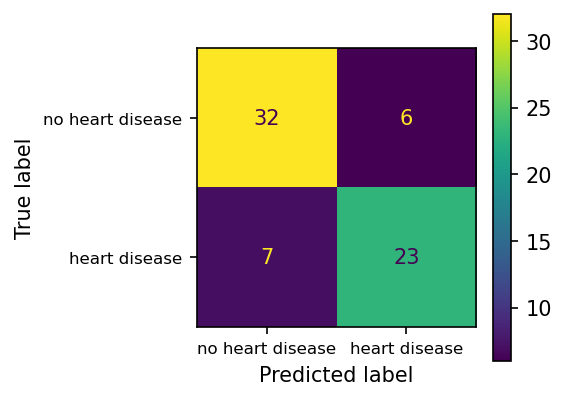

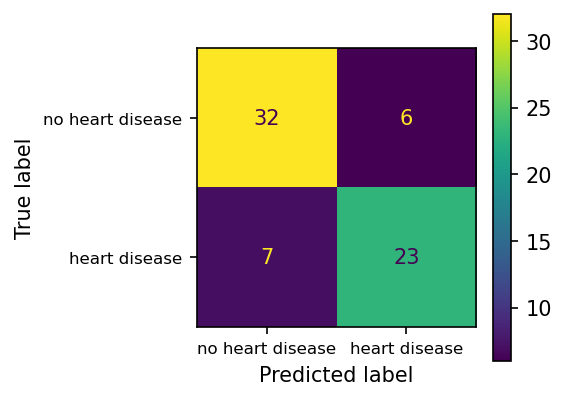

In [41]:
cm = confusion_matrix(ytestlrstrat, y_predict_test, labels = clf.classes_)
_, ax = plt.subplots()
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['no heart disease', 'heart disease'])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['no heart disease', 'heart disease'], fontsize = 8)
ax.set_yticklabels(labels = ['no heart disease', 'heart disease'], fontsize = 8)
display_cm.plot(ax = ax)

plt.show()

Note the ability to add human readable labels (as compared to just 0 or 1). From the chart we can see that while the overall accuracy was 81%, when we predict heart disease, 20% (6 of 29) of the time we are predicting a false positive, while the false negatives (predicting no disease when in fact there is heart disease) is about 18% (7 of 39). This information can be discussed with stakeholders to decide which is more important, reducing false positives or false negatives, assuming overall accuracy is acceptable. We can also use the ``classification_report`` method from earlier on this case--and notice that all the metrics in the report (precision, recall, and f1-score) can be computed from the values in the confusion matrix:

In [42]:
print(classification_report(ylrstrat, y_predict_training))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90       112
           1       0.90      0.84      0.87        90

    accuracy                           0.89       202
   macro avg       0.89      0.89      0.89       202
weighted avg       0.89      0.89      0.89       202



In [43]:
print(classification_report(ytestlrstrat, y_predict_test))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83        38
           1       0.79      0.77      0.78        30

    accuracy                           0.81        68
   macro avg       0.81      0.80      0.81        68
weighted avg       0.81      0.81      0.81        68



When the training accuracy is good, the test accuracy is somewhat worse than the training result. In such a case, as we introduced earlier, the model is slightly "overfitting" the training set. When there is evidence of overfitting, one must analyze the situation and suggest the course of action, typically aimed at "relaxing" the model--i.e., making it less strict.  This can seem counterintuitive at first!

Typically, the test accuracy, even when it is close to the training accuracy, tends to be smaller (worse) than the training accuracy (better).

When the test accuracy is significally better than the training accuracy, this would justify a review of the code to see if there is a bug. In such a case, plotting the performance results with multiple (random) splits of the same data would be one way to start investigating.

The code below shows one simple way to do it.

In [44]:
#
# here we try multiple splits and see the effects, with the same proportion 75% train and 25% test
#
# keep lists for training accuracy, 
#                test accuracy, 
#                and the difference between the latter and the former
#
training_accuracy = []
test_accuracy = []
accuracy_difference = []
#
# define number of trials
#
n_splits = 25
#
# define LogisticRegression object
#
clf = LogisticRegression(solver = 'newton-cg', max_iter = 500)
#
# loop over multiple trials
#
for i in range(0, n_splits):
#
# perform a split for this iteration, 
# using different random_state for every iteration
# this ensures each split is likely to be unique
#
    Xlr, Xtestlr, ylr, ytestlr = train_test_split(X, y, stratify = y, random_state = i)
#    
# fit the Classifier on the training set
#
    clf.fit(Xlr, ylr)
#
# predict the labels for the training data
#
    y_predict_training = clf.predict(Xlr)
#
# predict the labels for the test data
#
    y_predict_test = clf.predict(Xtestlr)
#
# save training set accuracy for this split
#
    tr_accuracy = accuracy_score(y_predict_training, ylr)
    training_accuracy.append(tr_accuracy)
#
# save test set accuracy for this split
#
    tst_accuracy = accuracy_score(y_predict_test, ytestlr)
    test_accuracy.append(tst_accuracy)
#
# save difference between the two acuracy values
#
    accuracy_difference.append(tst_accuracy - tr_accuracy)

The above code generates 25 unique experiments varying the train-test split indices within the original data.  Now we plot all the trials for both the training and test data, to compare the results.

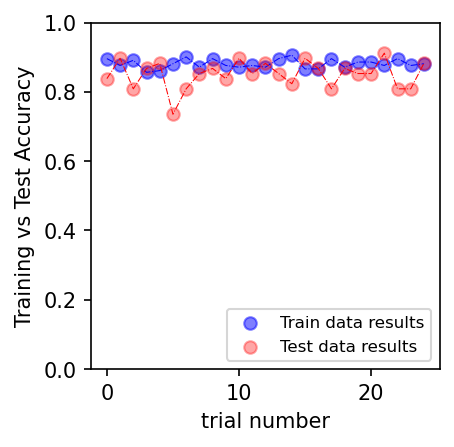

In [45]:
fig, ax = plt.subplots()
ax.scatter(range(len(training_accuracy)),
           training_accuracy, 
           color = 'blue', 
           alpha = 0.5,
           label = 'Train data results')
ax.plot(range(len(training_accuracy)),
        training_accuracy, 
        color = 'blue', 
        linestyle = '-.',
        linewidth = 0.5)
ax.scatter(range(len(test_accuracy)),
           test_accuracy, 
           color = 'red', 
           alpha = 0.35, 
           label = 'Test data results')
ax.plot(range(len(test_accuracy)),
        test_accuracy, 
        color = 'red', 
        linestyle = '-.',
        linewidth = 0.5)
ax.legend(fontsize = 8, loc = "lower right")
ax.set_ylabel('Training vs Test Accuracy')
ax.set_ylim(0, 1)
ax.set_xlabel('trial number')
plt.show()

Note that the accuracy on the train split is relatively constant. This is generally expected since the model is given the train data to fit. On the other hand, the test results vary somewhat more. Another way to look at these results is to plot the difference between the test accuracy and the train accuracy, which is done here.

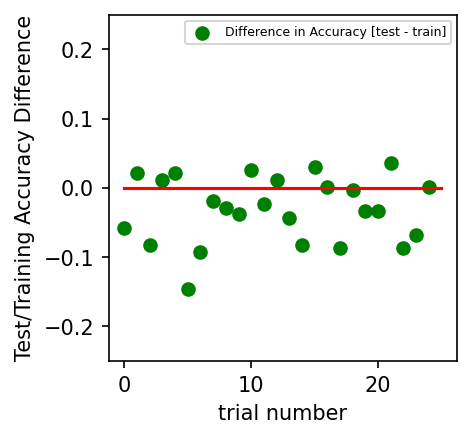

In [46]:
fig, ax = plt.subplots()
ax.scatter(range(len(accuracy_difference)),
           accuracy_difference, 
           color = 'green', 
           label = 'Difference in Accuracy [test - train]')
ax.plot([0, len(accuracy_difference)], [0, 0], 'red')
ax.legend(fontsize = 6)
ax.set_ylabel('Test/Training Accuracy Difference')
ax.set_ylim(-0.25, 0.25)
ax.set_xlabel('trial number')
plt.show()

In this case, the test accuracy is sometimes better, but not by very much--a maximum difference of no more than 0.15 units.  We've already noted that accuracy isn't always a good measure of model performance, and shown the use of the confusion matrix. Additional performance measures are provided by sklearn in the ``classifcation_report`` method (ref: [sklearn.metrics.classification_report](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html), including ``precision``, ``recall``, and ``f1-score``.  Note that if desired, we could graph multiple classification performance metrics similarly to the accuracy difference plot above. We won't do a deep dive on metrics here, but below we use the ``classification_report`` method to demonstrate the additional metrics. Note that since we didn't store the intermediate models, the following outputs results from the last of the 25 trials performed.

In [47]:
print("[Training Classification Report]")
print(classification_report(ylr, y_predict_training))
#
print("[Test Classification Report]")
print(classification_report(ytestlr, y_predict_test))

[Training Classification Report]
              precision    recall  f1-score   support

           0       0.88      0.91      0.89       112
           1       0.88      0.84      0.86        90

    accuracy                           0.88       202
   macro avg       0.88      0.88      0.88       202
weighted avg       0.88      0.88      0.88       202

[Test Classification Report]
              precision    recall  f1-score   support

           0       0.86      0.95      0.90        38
           1       0.92      0.80      0.86        30

    accuracy                           0.88        68
   macro avg       0.89      0.87      0.88        68
weighted avg       0.89      0.88      0.88        68



With the more detailed classification report, we see that the metrics are similar for the training and test sets. If you look back at the two plots, you will notice the last points for train and test are more or less on top of each other. The [ISLR book](http://www-bcf.usc.edu/~gareth/ISL/) has explanations of the meaning of these performance metrics, and the Wikipedia entries for them are also quite good (see [Precision and Recall](https://en.wikipedia.org/wiki/Precision_and_recall)).

## Logistic Regression Parameters in scikit-learn

It's a good habit to get into to use help(object) in Python to see details of the object.  If the object is a class from a large package like scikit-learn, you generally will get a version of the documentation similar to what you might find searching the web. By using help(), you are sure to get the information for the exact version you are using.  Here, use help(LogisticRegression) to get information about this class from scikit-learn.

In [48]:
help(LogisticRegression)

Help on class LogisticRegression in module sklearn.linear_model._logistic:

class LogisticRegression(sklearn.linear_model._base.LinearClassifierMixin, sklearn.linear_model._base.SparseCoefMixin, sklearn.base.BaseEstimator)
 |  LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='deprecated', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
 |
 |  Logistic Regression (aka logit, MaxEnt) classifier.
 |
 |  This class implements regularized logistic regression using the
 |  'liblinear' library, 'newton-cg', 'sag', 'saga' and 'lbfgs' solvers. **Note
 |  that regularization is applied by default**. It can handle both dense
 |  and sparse input. Use C-ordered arrays or CSR matrices containing 64-bit
 |  floats for optimal performance; any other input format will be converted
 |  (and copied).
 |
 |  The 'newton-cg', 'sag', and 'lbfgs' solvers support

You see in the help documentation all the paramters for which you can assign values to affect the behavior of the class when you use it.  In the above output, you are shown (among others--below we've omitted ones not of interest here--but feel free to experiment!).
  
penalty = 'l2'  
C = 1.0  
fit_intercept = True  
  
The values given after the equal sign are the default values; farther down in the documentation each parameter is defined and the possible / allowed values are detailed.  

### Tuning the Model

We've just seen that the scikit-learn logistic regression model has some adjustable parameters (*hyperparameters*) we can tune to optimize performance. Keep in mind that optimizing performance means we want to minimize the gap between the model performance on the training set and the test/validation set. It's possible to get a very good score on the training set but do poorly on the test set, due to what is called "overfitting'.  Overfitting refers to the case where the training performance is significantly higer than the test performance--this is caused by the model "memorizing" the training data. For tuning the parameters of your model, you will use a mix of *cross-validation* and *grid search*. In Logistic Regression, the most important parameter to tune is the *regularization parameter* ``C``. The regularization parameter is used to control for unlikely high regression coefficients, by adding a "penalty" to the loss term when the coefficients get larger.  For sklearn ``LogisticRegression``, ``C`` is the "inverse regularization strength", meaning smaller ``C`` constrains the paramters more. Also note that the actual penalty is determined by the "penalty" paramter, which defaults to ``l2``. l2 regularization uses a value ($\lambda$) multipled by the sum of the squares of the model coefficients.  l1 regularization multiples $\lambda$ by the sum of the absolute values of the weights. l2 is also called Ridge regularization (see section 3.4 and equation 3.41 in [The Elements of Statistical Learning](https://hastie.su.domains/Papers/ESLII.pdf)) and l1 is called Lasso regularization (see section 3.4 and equation 3.52, ibid).  So by default, smaller values of ``C`` will result in l2 regularization with larger $\lambda$ and a greater penalty on the larger model coefficients. Lastly, note that the default value for ``C`` is 1, and along with the default penaly l2, means scikit-learn Logistic Regression *always* uses regularization. If you would like to build Logistic Regression models without regularization, you can use statsmodels (*).

You will now implement some code to perform model tuning and selecting the regularization parameter ``C``.  
  
---
(*) [statsmodels.discrete.discrete_model.Logit](https://www.statsmodels.org/stable/discretemod.html)

#### Side-Bar: Cross Validation

Cross Validation refers to using a procedure to split the data into multiple train/validation splits, fitting a model using the training split, computing the performance metrics for the validation split over multiple splits. The metrics are typically averaged and the average value is reported as hopefully representative of what the model will do in the future on new data. Recall earlier we showed that across 25 splits the train and the test scores varied; a key idea behind cross validation is to avoid choosing a "lucky" split that happens to give great performance on the data at hand but does more poorly later.  Since the scores vary across random splits, it's assumed that the best score or the worst score aren't as likely to represent the future as an average. Some Data Scientists also report the standard deviation of the cv scores as a further measure of how confident they are in the score.

<b>To summarize</b>:
- the data are split multiple times (training/validation)
- a model is fit to the train data on each split
- the model is scored on the validation data on each split
- the average (and sometimes standard deviation) of the score is reported as the cv score

We use the following `cv_score` function to perform K-fold cross-validation and apply a scoring function to each test fold. A *fold* in this case just means a different split of the data, in this case random splits. The function generates five different splits (i.e. 5-fold validation), fits a classifier each time (note that the classifier is passed as a parameter to the function, so we can define it as anything that has a ``fit`` and ``predict`` method), and computes the "score", which by default is ``accuracy_score``. (Note the use of accuracy as the scoring metric--do you think this is the best approach for this problem?) Kfold is used to return sets of indices vs. the actual data, so the indices are generated, split, and passed as the vectors train, test to define the actual x and y data used on each pass. The scores are summed up in ``result``, and then the average is returned.

Please do not confuse the train/test split that is done in the cv_score function with the initial train/test split that one does before building the model. As you will notice below, when cv_score is called, the actual parameters that will be bound to the formal parameters x, y are X_train, and y_train, which come from the original split of (X, y).

In [49]:
def cv_score(clf, x, y, score_func = accuracy_score):
    result = 0
    nfold = 5
    x.reset_index(drop = True, inplace = True)
    y.index = x.index
    for train, test in KFold(nfold, shuffle = True,
                             random_state = 42).split(x):
        clf.fit(x.loc[train, :], y[train])
        result += score_func(clf.predict(x.loc[test, :]), y[test])
    return result / nfold

Below is an example of using the `cv_score` function for a basic logistic regression model without regularization.

In [50]:
clf = LogisticRegression(solver = 'liblinear', max_iter = 500)
score = cv_score(clf, Xlr, ylr)
print(f'{score:.2f}')

0.83


It's very important to understand this result. Earlier we showed that with different random splits, the train and test score would vary, and in our case the test score varied more than the train score. The key idea of cross-validation is to peform multiple splits. In this case, we defined our cv_score() function to return the average score across all splits. This is intended to be an estimate of the most likely performance of the model on unseen data. However, the actual results will still vary. Note that in this case the value is in between what we obtained with a single split for the train set and the test set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<b>Exercise:</b> Implement the following search procedure to find a good model
<ul>
<li> You are given a list of possible values of `C` below
<li> For each `C`:
  <ol>
  <li> Create a logistic regression model with that value of `C`
  <li> Find the average score for this model using the `cv_score` function **only on the training set** `(Xlr, ylr)`
  </ol>
<li> Pick the `C` with the highest average score
</ul><br>
Your goal is to find the best model parameters based *only* on the training set, without showing the model test set at all (which is why the test set is also called a *hold-out* set).  

Comment on the value of the score using the best `C` vs. what we had before.
</div>

C =   0.001, average CV score = 0.677
C =   0.100, average CV score = 0.826
C =   1.000, average CV score = 0.827
C =  10.000, average CV score = 0.822
C = 100.000, average CV score = 0.817

Best C value: 1
Best average CV score: 0.827


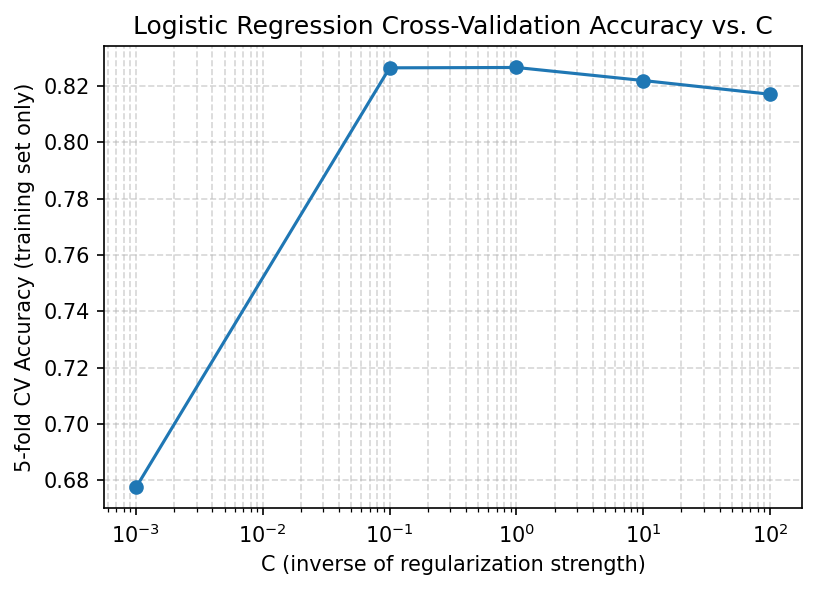

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,500
,multi_class,'deprecated'


In [51]:
#
# the grid of parameters to search over
#
Cs = [0.001, 0.1, 1, 10, 100]
#
# your turn

best_C = None
best_score = 0
cv_scores = []

for C in Cs:
    clf = LogisticRegression(solver='liblinear', max_iter=500, C=C)
    avg_score = cv_score(clf, Xlr, ylr)   # use only training data
    cv_scores.append(avg_score)
    print(f'C = {C:7.3f}, average CV score = {avg_score:.3f}')
    if avg_score > best_score:
        best_score = avg_score
        best_C = C

print('\nBest C value:', best_C)
print('Best average CV score:', f'{best_score:.3f}')

#
# visualize how CV score changes with C
#
plt.figure(figsize=(6, 4))
plt.semilogx(Cs, cv_scores, marker='o')
plt.xlabel('C (inverse of regularization strength)')
plt.ylabel('5-fold CV Accuracy (training set only)')
plt.title('Logistic Regression Cross-Validation Accuracy vs. C')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.show()

#
# Fit the best model on the full training set
#
clf_best = LogisticRegression(solver='liblinear', max_iter=500, C=best_C)
clf_best.fit(Xlr, ylr)

**Comment:**  
The best value of \( C \) was **1**, giving an average 5-fold cross-validation accuracy of **0.827**.  
This indicates that moderate regularization provides the best generalization performance, balancing bias and variance.


<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3><br>
    <b>Exercise:</b> Now you want to estimate how this model will predict on unseen data in the following way:
<ol>
    <li> Use the <i>C</i> you obtained from the procedure earlier and train a Logistic Regression on the training data
<li> Calculate the accuracy on the test data
</ol>

You may notice that this particular value of <i>C</i> may or may not do as well as simply running the default model on a random train-test split.

<ul>
<li> Do you think that's a problem? 
<li> Why do we need to do this whole cross-validation and grid search stuff anyway?
</ul>

</div>

In [56]:
#
# Checkup Exercise Set III
#

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

#
# 1. Train the final model using the best C from cross-validation
#
clf_final = LogisticRegression(solver='liblinear', max_iter=500, C=best_C)
clf_final.fit(Xlr, ylr)

#
# 2. Evaluate accuracy on the test data (unseen data)
#
y_pred = clf_final.predict(Xtestlr)
test_accuracy = accuracy_score(ytestlr, y_pred)

print(f"Best C from cross-validation: {best_C}")
print(f"Test Accuracy using best C: {test_accuracy:.3f}")



Best C from cross-validation: 1
Test Accuracy using best C: 0.882


The best value of **C = 1** gave a test accuracy of **0.882** on unseen data.  
This performance is quite strong and close to what we observed during cross-validation, confirming that the model generalizes well.

Even if the tuned model had performed slightly worse than the default model on this specific train–test split, **that would not be a problem**.  
Cross-validation and grid search are not designed to make the model perfect on one random split — their purpose is to **reduce randomness** and **select the most reliable model** overall.

By evaluating performance across multiple folds of the training data, cross-validation:
- Avoids over-reliance on a single “lucky” or “unlucky” split.  
- Provides a more stable estimate of future performance.  
- Helps us choose the optimal regularization parameter **C**, balancing bias and variance.

In short, cross-validation and grid search give us **confidence that our chosen model (C = 1)** will perform consistently well on *new, unseen data*, rather than just fitting one particular random subset of the dataset.


### Black Box Grid Search in `sklearn`

Scikit-learn, as with many other Python packages, provides utilities to perform common operations so you do not have to implement them yourself. It is important to understand the mechanics of each operation, but at a certain point, you will want to use the utility instead to save time...

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<b>Exercise:</b> Use scikit-learn's [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html) tool to perform cross validation and grid search. 

* Instead of writing your own loops above to iterate over the model parameters, can you use GridSearchCV to find the best model over the training set? 
* Does it give you the same best value of C?
* How does this model you've obtained perform on the test set?

In [59]:
#
# your turn
#

# --- Parameter grid (same as before to compare apples-to-apples) ---
Cs = [0.001, 0.1, 1, 10, 100]
param_grid = {"C": Cs}

# --- Estimator and CV splitter ---
# Use KFold with the same settings as your custom cv_score() for consistency
cv = KFold(n_splits=5, shuffle=True, random_state=42)
estimator = LogisticRegression(solver="liblinear", max_iter=500)

# --- Grid search over C using accuracy (default scoring) ---
grid = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1,
    return_train_score=True
)

# Fit on TRAINING split only
grid.fit(Xlr, ylr)

# --- Results summary ---
best_C_gs = grid.best_params_["C"]
best_cv_score = grid.best_score_
print(f"Best C from GridSearchCV: {best_C_gs}")
print(f"Best mean CV accuracy (5-fold): {best_cv_score:.3f}")

# Nicely formatted CV table
cv_df = pd.DataFrame(grid.cv_results_)
cv_view = (
    cv_df[["param_C", "mean_train_score", "std_train_score", "mean_test_score", "std_test_score", "rank_test_score"]]
    .rename(columns={
        "param_C": "C",
        "mean_train_score": "mean_train_acc",
        "std_train_score": "std_train_acc",
        "mean_test_score": "mean_cv_acc",
        "std_test_score": "std_cv_acc",
        "rank_test_score": "rank"
    })
    .sort_values(by="C")
)
print("\nCross-validation results by C:")
print(cv_view.to_string(index=False, float_format=lambda x: f"{x:.3f}"))

# --- Does it match the manual search best_C (if defined previously)? ---
try:
    print(f"\nMatches manual best_C? {best_C_gs == best_C}  (manual best_C = {best_C})")
except NameError:
    print("\nManual best_C not found in this session. (If you defined best_C earlier, run this cell after that.)")

# --- Evaluate the best model on the TEST split ---
best_model = grid.best_estimator_
y_pred = best_model.predict(Xtestlr)
test_acc = accuracy_score(ytestlr, y_pred)
print(f"\nTest accuracy using GridSearchCV-selected C: {test_acc:.3f}")



Best C from GridSearchCV: 1
Best mean CV accuracy (5-fold): 0.827

Cross-validation results by C:
      C  mean_train_acc  std_train_acc  mean_cv_acc  std_cv_acc  rank
  0.001           0.694          0.011        0.677       0.081     5
  0.100           0.871          0.005        0.826       0.060     2
  1.000           0.889          0.009        0.827       0.050     1
 10.000           0.890          0.007        0.822       0.045     3
100.000           0.891          0.008        0.817       0.050     4

Matches manual best_C? True  (manual best_C = 1)

Test accuracy using GridSearchCV-selected C: 0.882


Using **GridSearchCV**, we performed a systematic cross-validation and parameter search across different values of \( C \).

- **Best C value:** 1  
- **Mean 5-fold CV accuracy:** 0.827  
- **Test accuracy using best model:** 0.882  

**Comparison with manual grid search:**  
GridSearchCV found the **same best C value (C = 1)** as our manual search, confirming that both approaches are consistent. The mean cross-validation accuracy also matches closely (0.827), verifying that our custom `cv_score()` implementation worked correctly.

**Model performance:**  
The test accuracy (0.882) indicates strong generalization on unseen data, aligning with what we obtained earlier. This consistency suggests that our model is well-regularized and neither overfitting nor underfitting.

**Why use GridSearchCV?**  
Instead of manually looping through parameters, GridSearchCV automates:
- Splitting the data into folds for cross-validation,  
- Training and scoring the model for each parameter combination,  
- Selecting the best parameter set automatically,  
- Returning both the best model and all intermediate results.

This ensures a **robust, reproducible, and less error-prone** process compared to manual iteration — especially when dealing with more complex models or multiple hyperparameters.


So in a few lines of code, utilizing the functionality provied by scikit-learn, you can reproduce what took about 20 lines of code "from scratch". The goal here was to illustrate how to understand what is occurring when you use these advanced features.  It's always a good idea to do some experimenting and exploring to ensure you understand the tools you are using!

### Summary



This case study has introduced using the Logistic Regression algorithm to classify a binary outcome, in this case the presence or absence of heart disease. You have seen how to tune a hyperparamter *C*, the  "inverse regularization strength" to get a model that has a good average cross-vaidation score on the held-out data.  

Logistic regression is an excellent choice for a "baseline" classifier, even when you plan to test more complicated algorithms on a problem. Have a well-performing baseline makes it more clear when using a more complex method adds value.

## Optional: Appendix  
#### Note: 
Most of the following material is taken verbatim from the Logistic Regression section of the CS109 tutorial found at https://github.com/cs109/2015lab5/blob/master/Classification.ipynb

### A Walkthrough of the Math Behind Logistic Regression

We could approach classification as linear regression, where the class, 0 or 1, is the target variable $y$. But this ignores the fact that our output $y$ is discrete valued, and futhermore, the $y$ predicted by linear regression will in general take on values less than 0 and greater than 1. Thus this does not seem like a very good idea.

But what if we could change the form of our hypotheses $h(x)$ instead?

The idea behind logistic regression is very simple. We want to draw a line in feature space that divides the '1' samples from the '0' samples, just like in the diagram above. In other words, we wish to find the "regression" line which divides the samples. Now, a line has the form $w_1 x_1 + w_2 x_2 + w_0 = 0$ in 2-dimensions. On one side of this line we have 

$$w_1 x_1 + w_2 x_2 + w_0 \ge 0,$$

and on the other side we have 

$$w_1 x_1 + w_2 x_2 + w_0 < 0.$$ 

Our classification rule then becomes:

\begin{eqnarray*}
y = 1\;\; &if&\; \textbf{w}\cdot\textbf{x} \ge 0\\
y = 0\;\; &if&\; \textbf{w}\cdot\textbf{x} < 0
\end{eqnarray*}

where $ \textbf{x}$ is the vector $\{1,x_1, x_2,...,x_n\}$ where we have also generalized to more than 2 features.

What hypotheses $h$ can we use to achieve this? One way to do so is to use the **sigmoid** function:

$$h(z) = \frac{1}{1 + e^{-z}}.$$

Notice that at $z=0$ this function has the value 0.5. If $z > 0$, $h > 0.5$ and as $z \to \infty$, $h \to 1$. If $z < 0$, $h < 0.5$ and as $z \to -\infty$, $h \to 0$. As long as we identify any value of $y > 0.5$ as 1, and any $y < 0.5$ as 0, we can achieve what we wished above.

This function is plotted below:

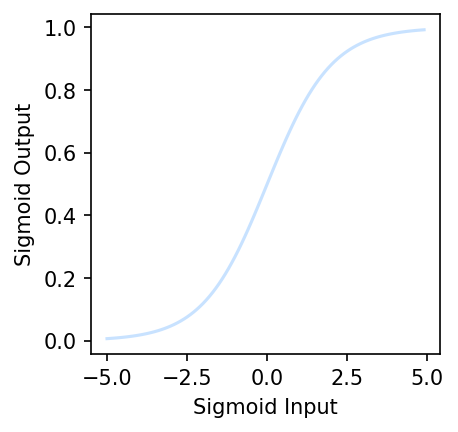

In [46]:
h = lambda z: 1. / (1 + np.exp(-z))
zs = np.arange(-5, 5, 0.1)
fig, ax = plt.subplots()
ax.plot(zs, h(zs), alpha=0.5)
ax.set_ylabel('Sigmoid Output')
ax.set_xlabel('Sigmoid Input')
plt.show()

You can see the effect of the Sigmoid function is to "squash" the input values to between 0 and 1, and because of the steep slope in the middle, it will tend to output values towards 0 or 1 if the input is somewhat different than 0.

So we then come up with our rule by identifying:

$$z = \textbf{w}\cdot\textbf{x}.$$

Then $h(\textbf{w}\cdot\textbf{x}) \ge 0.5$ if $\textbf{w}\cdot\textbf{x} \ge 0\;$  and  $\;h(\textbf{w}\cdot\textbf{x}) \lt 0.5$ if $\textbf{w}\cdot\textbf{x} \lt 0$, and:

\begin{eqnarray*}
y = 1 \;\; &if&\; h(\textbf{w}\cdot\textbf{x}) \ge 0.5\\
y = 0 \;\; &if&\; h(\textbf{w}\cdot\textbf{x}) \lt 0.5.
\end{eqnarray*}

We will show soon that this identification can be achieved by minimizing a loss in the ERM framework called the **log loss** :

$$ R_{\cal{D}}(\textbf{w}) = - \sum_{y_i \in \cal{D}} \left ( y_i \log(h(\textbf{w}\cdot\textbf{x})) + ( 1 - y_i) \log(1 - h(\textbf{w}\cdot\textbf{x})) \right )$$

We will also add a regularization term:

$$ R_{\cal{D}}(\textbf{w}) = - \sum_{y_i \in \cal{D}} \left ( y_i \log(h(\textbf{w}\cdot\textbf{x})) + ( 1 - y_i) \log(1 - h(\textbf{w}\cdot\textbf{x})) \right ) + \frac{1}{C} \textbf{w}\cdot\textbf{w},$$

where $C$ is the regularization strength (equivalent to $1/\alpha$ from the Ridge case), and smaller values of $C$ mean stronger regularization. As before, the regularization tries to prevent features from having terribly high weights, thus implementing a form of feature selection. 

How did we come up with this loss? We'll come back to that, but let us see how logistic regression works out. 


### The Probabalistic Interpretation

Remember we said earlier that if $h > 0.5$ we ought to identify the sample with $y=1$? One way of thinking about this is to identify $h({w}\cdot{x})$ with the probability that the sample is a '1'  $\;$($y=1$). Then we have the intuitive notion that lets identify a sample as 1 if we find that the probabilty of being a '1' is $\;\ge 0.5$.

So suppose we say then that the probability of $y=1$ for a given $\textbf{x}$ is given by $h(\textbf{w}\cdot\textbf{x})$?

Then, the conditional probabilities of $y=1$ or $y=0$ given a particular sample's features $\v{x}$ are:

\begin{eqnarray*}
P(y=1 | \textbf{x}) &=& h(\textbf{w}\cdot\textbf{x}) \\
P(y=0 | \textbf{x}) &=& 1 - h(\textbf{w}\cdot\textbf{x}).
\end{eqnarray*}

These two can be written together as

$$P(y|\textbf{x}, \textbf{w}) = h(\textbf{w}\cdot\textbf{x})^y \left(1 - h(\textbf{w}\cdot\textbf{x}) \right)^{(1-y)} $$

Then multiplying over the samples we get the probability of the training $y$ given $\textbf{w}$ and the $\textbf{x}$:

$$P(y|\textbf{x},\textbf{w}) = P(\{y_i\} | \{\textbf{x}_i\}, \textbf{w}) = \prod_{y_i \in \cal{D}} P(y_i|\textbf{x_i}, \textbf{w}) = \prod_{y_i \in \cal{D}} h(\textbf{w}\cdot\textbf{x_i})^{y_i} \left(1 - h(\textbf{w}\cdot\textbf{x_i}) \right)^{(1-y_i)}$$

Why use probabilities? Earlier, we talked about how the regression function $f(x)$ never gives us the $y$ exactly, because of noise. This hold for classification too. Even with identical features, a different sample may be classified differently. 

We said that another way to think about a noisy $y$ is to imagine that our data $\mathcal{D}$ was generated from  a joint probability distribution $P(x,y)$. Thus we need to model $y$ at a given $x$, written as $P(y|x)$, and since $P(x)$ is also a probability distribution, we have:

$$P(x,y) = P(y | x) P(x)$$

and can obtain our joint probability $P(x, y)$.

Indeed its important to realize that a particular training set can be thought of as a draw from some "true" probability distribution (just as we did when showing the hairy variance diagram). If for example the probability of classifying a test sample as a '0' was 0.1, and it turns out that the test sample was a '0', it does not mean that this model was necessarily wrong. After all, in roughly a 10th of the draws, this new sample would be classified as a '0'! But, of-course its more unlikely than its likely, and having good probabilities means that we'll be likely right most of the time, which is what we want to achieve in classification. And furthermore, we can quantify this accuracy.

Thus its desirable to have probabilistic, or at the very least, ranked models of classification where you can tell which sample is more likely to be classified as a '1'. There are business reasons for this too. Consider the example of customer "churn": you are a cell-phone company and want to know, based on some of my purchasing habit and characteristic "features" if I am a likely defector. If so, you'll offer me an incentive not to defect. In this scenario, you might want to know which customers are most likely to defect, or even more precisely, which are most likely to respond to incentives. Based on these probabilities, you could then spend a finite marketing budget wisely.

### Maximizing the Probability of the Training Set

Now if we maximize $P(y|\textbf{x},\textbf{w})$, we will maximize the chance that each point is classified correctly, which is what we want to do. While this is not exactly the same thing as maximizing the 1-0 training risk, it is a principled way of obtaining the highest probability classification. This process is called **maximum likelihood** estimation since we are maximising the **likelihood of the training data y**, 

$$\mathcal{L} = P(y|\textbf{x},\textbf{w}).$$ 

Maximum likelihood is one of the corenerstone methods in statistics, and is used to estimate probabilities of data. 

We can equivalently maximize 

$$\ell = \log{P(y|\textbf{x},\textbf{w})}$$ 

since the natural logarithm $\log$ is a monotonic function. This is known as maximizing the **log-likelihood**. Thus we can equivalently *minimize* a risk that is the negative of  $\log(P(y|\textbf{x},\textbf{w}))$:

$$R_{\cal{D}}(h(x)) = -\ell = -\log \mathcal{L} = -\log{P(y|\textbf{x},\textbf{w})}$$


Thus

\begin{eqnarray*}
R_{\cal{D}}(h(x)) &=& -\log\left(\prod_{y_i \in \cal{D}} h(\textbf{w}\cdot\textbf{x_i})^{y_i} \left(1 - h(\textbf{w}\cdot\textbf{x_i}) \right)^{(1-y_i)}\right)\\
                  &=& -\sum_{y_i \in \cal{D}} \log\left(h(\textbf{w}\cdot\textbf{x_i})^{y_i} \left(1 - h(\textbf{w}\cdot\textbf{x_i}) \right)^{(1-y_i)}\right)\\                  
                  &=& -\sum_{y_i \in \cal{D}} \log\,h(\textbf{w}\cdot\textbf{x_i})^{y_i} + \log\,\left(1 - h(\textbf{w}\cdot\textbf{x_i}) \right)^{(1-y_i)}\\
                  &=& - \sum_{y_i \in \cal{D}} \left ( y_i \log(h(\textbf{w}\cdot\textbf{x})) + ( 1 - y_i) \log(1 - h(\textbf{w}\cdot\textbf{x})) \right )
\end{eqnarray*}
                  
This is exactly the risk we had above, leaving out the regularization term (which we shall return to later) and was the reason we chose it over the 1-0 risk. 

Notice that this little process we carried out above tells us something very interesting: **Probabilistic estimation using maximum likelihood is equivalent to Empiricial Risk Minimization using the negative log-likelihood**, since all we did was to minimize the negative log-likelihood over the training samples.

`sklearn` will return the probabilities for our samples, or for that matter, for any input vector set $\{\textbf{x}_i\}$, i.e. $P(y_i | \textbf{x}_i, \textbf{w})$:

Let us plot the probabilities obtained from `predict_proba`, overlayed on the samples with their true labels:

In [47]:
clf.predict_proba(Xtestlr)

array([[0.0137108 , 0.9862892 ],
       [0.00540014, 0.99459986],
       [0.02372191, 0.97627809],
       [0.13594937, 0.86405063],
       [0.89512288, 0.10487712],
       [0.78973913, 0.21026087],
       [0.96625268, 0.03374732],
       [0.49761096, 0.50238904],
       [0.82929914, 0.17070086],
       [0.95626833, 0.04373167],
       [0.45401096, 0.54598904],
       [0.45796068, 0.54203932],
       [0.93677382, 0.06322618],
       [0.88748086, 0.11251914],
       [0.95535549, 0.04464451],
       [0.08067024, 0.91932976],
       [0.00336342, 0.99663658],
       [0.97142627, 0.02857373],
       [0.88721313, 0.11278687],
       [0.04835207, 0.95164793],
       [0.00164187, 0.99835813],
       [0.92405638, 0.07594362],
       [0.2436495 , 0.7563505 ],
       [0.03802645, 0.96197355],
       [0.01198101, 0.98801899],
       [0.89601299, 0.10398701],
       [0.97833617, 0.02166383],
       [0.98142395, 0.01857605],
       [0.85158141, 0.14841859],
       [0.24964455, 0.75035545],
       [0.

To illustrate further, we return to our simplistic two-feature classifier we created earlier:

In [48]:
Xtrain, Xtest, ytrain, ytest = \
    train_test_split(dflog[['cholesterol_mg_dl','resting_BP_mm_Hg']],
                     dflog['heart_disease'],
                     train_size = 0.80,
                     random_state = 42)
classifier = LogisticRegression(solver = 'liblinear', max_iter = 500, C = 1000)
classifier.fit(Xtrain, ytrain)

LogisticRegression(C=1000, max_iter=500, solver='liblinear')

In this case, we will use the other function we defined, to label the points using the *predicted* values (earlier we labeled them with their actual values) and label the probabilities output by the classifier. 

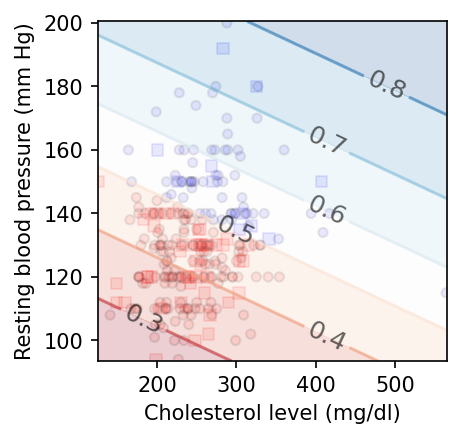

In [49]:
plt.figure()
ax = plt.gca()
ax.set_ylabel('Resting blood pressure (mm Hg)')
ax.set_xlabel('Cholesterol level (mg/dl)')
_ = points_plot_prob(ax, Xtrain, Xtest, ytrain, ytest, classifier, psize = 20, alpha = 0.1)

Notice that lines of equal probability, as might be expected are stright lines. What the classifier does is very intuitive: if the probability is greater than 0.5, it classifies the sample as type '1' (has heart disease), otherwise it classifies the sample to be class '0' (no heart disease). Thus in the diagram above, where we have plotted predicted values rather than actual labels of samples, there is a clear demarcation at the 0.5 probability line.

Again, this notion of trying to obtain the line or boundary of demarcation is what is called a **discriminative** classifier. The algorithm tries to find a decision boundary that separates those who have heart disease from those who do not. To classify a new sample, it checks on which side of the decision boundary the sample falls, and makes a prediction. In other words we are asking, given $\textbf{x}$, what is the probability of a given $y$, or, what is the likelihood $P(y|\textbf{x},\textbf{w})$?

### Discriminative vs Generative Classifiers

Logistic regression is what is known as a **discriminative classifier** as we learn a soft boundary between/among classes. Another paradigm is the **generative classifier** where we learn the distribution of each class. For more examples of generative classifiers, look [here](https://en.wikipedia.org/wiki/Generative_model). 